## All the import

In [1]:
import numpy as np
import RNA
from random import randint
import matplotlib.pyplot as plt
import pdb
from math import  sqrt
import pandas as pd
import csv

## Load the data

In [2]:
'''
Generate a sequence : random succession of 'a' 'g' 'c' 'u' of size longueur
'''
def generate_rna(longueur):
    seq = ''
    for i in range(longueur):
        rand=randint(0,3)
        if rand == 0:
            seq = seq + 'a'
        elif rand == 1:
            seq = seq + 'g'
        elif rand == 2:
            seq = seq + 'c'
        else:
            seq = seq + 'u'
    return seq

In [4]:
'''
Return the prediction array :
if structure[i] is parenthese then prediction[i] = 1
if structure has more than 10 parentheses in interaction site locate between 85 and 85+longueur
then all the value of prediction array between the 85th and 85+longueur th would be set to 1
'''
def get_predictions(structure, longueur, sense = 0):
    length = len(structure)
    prediction = np.zeros(length)
    index = 0
    nbparent = 0
    
    if(sense != 0):
        structure = structure[::-1]

    for char in structure[:85]:
        if char == '(' or char == ')':
            prediction[index] = 1
            index+=1
    
    for char in structure[85:85+longueur]:
        if char == '(' or char == ')':
            prediction[index] = 1
            nbparent+=1
        if(nbparent == 10):
            ones = np.ones(longueur)
            for i in range(longueur):
                prediction[i+85] = ones[i]
            break
        index+=1
    
    index = 85 + longueur
    for char in structure[85+longueur:]:
        if char == '(' or char == ')':
            prediction[index] = 1
        index+=1
    
    return prediction

In [5]:
'''
Return the structures of the two sequence calculated by RNA Subopt
'''
def get_rna_subopt(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA subopt")
    
    a = RNA.subopt(s1+'&'+s2, '', 10)
    
    struct1,struct2 = a.structure.split('&')
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)

    return prediction1, prediction2

In [6]:
'''
Return the structures of the two sequence calculated by RNA Duplex
'''
def get_rna_duplex(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA duplex")
    
    a = RNA.duplexfold(s1,s2)
    struct1,struct2 = a.structure.split('&')
    
    i = int(a.i)
    j = int(a.j)
    len1 = len(s1)
    len2 = len(s2)
    
    #Adapt the structure because RNADuplex doesn't return a structure of the size of the sequence
    temp1 = '.'*(i-len(struct1))
    temp2 = '.'*(len1-i)
    struct1 = temp1+struct1+temp2
    
    temp1 = '.'*(j-1)
    temp2 = '.'*(len2-len(struct2)-j+1)
    struct2=temp1+struct2+temp2
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)
    
    return prediction1, prediction2

In [7]:
'''
Return the accuracy, precision, sensitivity, specificity
by comparing pred_y and labels, test_num is the length of the tab
'''
def calculate_performance(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1               
            
    acc = float(tp + tn)/test_num
    
    if (tp+fp) == 0:
        precision = 0
    else:
        precision = float(tp)/(tp+ fp)
    
    if (tp+fn) == 0:
        sensitivity = 0
    else:
        sensitivity = float(tp)/ (tp+fn)
    
    if (tn+fp) == 0:
        specificity = 0  
    else:
        specificity = float(tn)/(tn + fp)
    
    MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    print("Accuracy : ", acc)
    print("Precision : ", precision)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("MCC : ", MCC)
    return acc, precision, sensitivity, specificity, MCC

In [8]:
'''
Load the benchmark database and return it in several arrays
'''
def load_benchmark():
    print("Loading benchmark database")
    datatest = pd.read_csv("genomes/benchmark_interactionsv2.csv", sep = "\t", header=None)
    datatest = np.array(datatest)
    sequence1=[]
    sequence2=[]
    longueur1=[]
    longueur2=[]
    l = len(datatest)
    for i in range(l):
        #Treadtment and formatting of the database
        data = datatest[i][0].split(' ')
        data[0] = data[0].split('[')
        data[0][1] = data[0][1].split('\n')
        data[1] = data[1].split('\n')
        
        seq1=data[0][1][0]
        seq2=data[1][0]
        len1=int(data[2])
        len2=int(data[3])
        
        sequence1.append(seq1)
        sequence2.append(seq2)
        longueur1.append(len1)
        longueur2.append(len2)
    
    print("Benchmark database loaded")
    return sequence1, sequence2, longueur1, longueur2

In [13]:
'''
Calculate the performance of RNA Subopt and RNA Duplex and return them in two list,
one per tool. Each list contain 5 arrays : 
[ accuracy, precision, sensitivity, specificity, mcc ]
'''
def get_score_RNA():
    benchmark = load_benchmark()
    
    sequence1 = benchmark[0]
    sequence2 = benchmark[1]
    longueur1 = benchmark[2]
    longueur2 = benchmark[3]
    
    subopt_accuracy = []
    subopt_precision = []
    subopt_sensitivity = []
    subopt_specificity = []
    subopt_mcc = []
    
    duplex_accuracy = []
    duplex_precision = []
    duplex_sensitivity = []
    duplex_specificity = []
    duplex_mcc = []
    
    length = len(sequence1)
    
    print("Executing")
    
    for i in range(length):
        print("Index : ", i)
        seq1 = sequence1[i]
        seq2 = sequence2[i]
        #length of the interaction site in each sequence
        len1 = longueur1[i]
        len2 = longueur2[i]
        
        label1 = np.zeros(len(seq1))
        label2 = np.zeros(len(seq2))
        ones1 = np.ones(len1)
        ones2 = np.ones(len2)
        label1[85:85+len1] = ones1[:]
        label2[85:85+len2] = ones2[:]
        labels = np.concatenate((label1, label2), axis=0)
        
        prediction1, prediction2 = get_rna_subopt(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        subopt_accuracy.append(performance[0])
        subopt_precision.append(performance[1])
        subopt_sensitivity.append(performance[2])
        subopt_specificity.append(performance[3])
        subopt_mcc.append(performance[4])
        
        prediction1, prediction2 = get_rna_duplex(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        duplex_accuracy.append(performance[0])
        duplex_precision.append(performance[1])
        duplex_sensitivity.append(performance[2])
        duplex_specificity.append(performance[3])
        duplex_mcc.append(performance[4])
        
    #Bring together all the performance arrays
    subopt = []
    subopt.append(subopt_accuracy)
    subopt.append(subopt_precision)
    subopt.append(subopt_sensitivity)
    subopt.append(subopt_specificity)
    subopt.append(subopt_mcc)
    
    duplex = []
    duplex.append(duplex_accuracy)
    duplex.append(duplex_precision)
    duplex.append(duplex_sensitivity)
    duplex.append(duplex_specificity)
    duplex.append(duplex_mcc)
    
    return subopt, duplex

In [10]:
'''
Save the performance arrays in severals files, one file per array
tab is one of the tab retruned by the function get_score_RNA()
filename is the name of the tool like in the function above
'''
def save_performances(tab,filename):
    print("Saving the performances of " + filename)
    
    #Extract the different arrays
    accuracy = np.array(tab[0])
    precision = np.array(tab[1])
    sensitivity = np.array(tab[2])
    specificity = np.array(tab[3])
    mcc = np.array(tab[4])
    
    #Saving the arrays in different npy files
    np.save('benchmark_result/'+filename+'_accuracy.npy', accuracy)
    np.save('benchmark_result/'+filename+'_precision.npy', accuracy)
    np.save('benchmark_result/'+filename+'_sensitivity.npy', accuracy)
    np.save('benchmark_result/'+filename+'_specificity.npy', accuracy)
    np.save('benchmark_result/'+filename+'_mcc.npy', accuracy)
    print("Performances of " + filename + " saved")

In [11]:
'''
This function load the arrays : accuracy, precision, sensitivity, specificity, mcc
of the tools on the benchmark database extracted from RISE
use 'subopt' for RNA Subopt
and 'duplex' for RNA Duplex
Plot the differents array on differents figures and save the graph
in several png file and return the different arrays
'''
def load_performances(filename):
    print("Loading the performances of " + filename)
    
    #Load all the performance arrays array from .npy files
    accuracy = np.load('benchmark_result/'+filename+'_accuracy.npy')
    precision = np.load('benchmark_result/'+filename+'_precision.npy')
    sensitivity = np.load('benchmark_result/'+filename+'_sensitivity.npy')
    specificity = np.load('benchmark_result/'+filename+'_specificity.npy')
    mcc = np.load('benchmark_result/'+filename+'_mcc.npy')
    length = len(accuracy)
    
    #Print the performance arrays with matplotlib and save the graph in png files
    x = np.linspace(1,length,length)
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p1=plt.plot(x,accuracy,label='Accuracy',marker='o')
    fig1.savefig('benchmark_result/'+filename+'_accuracy.png')
    fig2 = plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p1=plt.plot(x,precision,label='Precision',marker='x')
    fig2.savefig('benchmark_result/'+filename+'_precision.png')
    fig3 = plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p2=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    fig3.savefig('benchmark_result/'+filename+'_sensitivity.png')
    fig4 = plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p3=plt.plot(x,specificity, label='Specificity',marker='p')
    fig4.savefig('benchmark_result/'+filename+'_specificity.png')
    fig5 = plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p4=plt.plot(x,mcc, label='MCC',marker='v')
    fig5.savefig('benchmark_result/'+filename+'_MCC.png')
    plt.show()
    
    return accuracy, precision, sensitivity, specificity, mcc

In [12]:
def plot_performances(tab, longueur = 0):
    if longueur == 0:
        length = len(tab)
    else :
        if longueur < len(tab):
            length = longueur
        else:
            length = len(tab)
    
    accuracy = np.zeros(length)
    precision = np.zeros(length)
    sensitivity = np.zeros(length)
    specificity = np.zeros(length)
    mcc = np.zeros(length)
    
    for i in range(length):
        accuracy[i]=tab[0][i]
        precision[i]=tab[1][i]
        sensitivity[i]=tab[2][i]
        specificity[i]=tab[3][i]
        mcc[i]=tab[4][i]
        
    x = np.linspace(1,length,length)
    plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p1=plt.plot(x,accuracy,label='Accuracy',marker='o')
    plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p1=plt.plot(x,precision,label='Precision',marker='x')
    plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p2=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p3=plt.plot(x,specificity, label='Specificiy',marker='p')
    plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p4=plt.plot(x,mcc, label='MCC',marker='v')
    plt.show()

In [52]:
subopt, duplex = get_score_RNA()

Loading benchmark database
Benchmark database loaded
Executing
Index :  0
RNA subopt
Accuracy :  0.5876288659793815
Sensitivity :  0.0
Specificity :  0.6627906976744186
MCC :  -0.23355633926633443
RNA duplex
Accuracy :  0.6443298969072165
Sensitivity :  0.0
Specificity :  0.7267441860465116
MCC :  -0.2022261801513773
Index :  1
RNA subopt
Accuracy :  0.38765432098765434
Sensitivity :  0.4918032786885246
Specificity :  0.3691860465116279
MCC :  -0.10193310891941453
RNA duplex
Accuracy :  0.47160493827160493
Sensitivity :  0.4918032786885246
Specificity :  0.4680232558139535
MCC :  -0.028776834543401342
Index :  2
RNA subopt
Accuracy :  0.40616966580976865
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.23142576942574322
RNA duplex
Accuracy :  0.455012853470437
Sensitivity :  0.5111111111111111
Specificity :  0.4476744186046512
MCC :  -0.026484334529956684
Index :  3
RNA subopt
Accuracy :  0.6932989690721649
Sensitivity :  0.4318181818181818
Specificity :  0.72674418604651

Accuracy :  0.48704663212435234
Sensitivity :  0.5476190476190477
Specificity :  0.4796511627906977
MCC :  0.017002303297156945
Index :  32
RNA subopt
Accuracy :  0.40601503759398494
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.24204860643085607
RNA duplex
Accuracy :  0.44360902255639095
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2653640912315012
Index :  33
RNA subopt
Accuracy :  0.4255874673629243
Sensitivity :  0.48717948717948717
Specificity :  0.4186046511627907
MCC :  -0.057582639408676375
RNA duplex
Accuracy :  0.4151436031331593
Sensitivity :  0.5128205128205128
Specificity :  0.40406976744186046
MCC :  -0.051055618305405163
Index :  34
RNA subopt
Accuracy :  0.46113989637305697
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.2577180720305869
RNA duplex
Accuracy :  0.48186528497409326
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.269537370328234
Index :  35
RNA subopt
Accuracy :  0.71571072319202
Sensitivity :  1.

RNA subopt
Accuracy :  0.37789203084832906
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.2156185757983688
RNA duplex
Accuracy :  0.455012853470437
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.25920742606923175
Index :  66
RNA subopt
Accuracy :  0.4005037783375315
Sensitivity :  0.660377358490566
Specificity :  0.36046511627906974
MCC :  0.014789455266781857
RNA duplex
Accuracy :  0.5314861460957179
Sensitivity :  0.660377358490566
Specificity :  0.5116279069767442
MCC :  0.11703345170451594
Index :  67
RNA subopt
Accuracy :  0.4580152671755725
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26687249808205815
RNA duplex
Accuracy :  0.48091603053435117
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2807518172088513
Index :  68
RNA subopt
Accuracy :  0.41794871794871796
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.23939291990296574
RNA duplex
Accuracy :  0.49230769230769234
Sensitivity :  1.0
Specificity :  

Accuracy :  0.35917312661498707
Sensitivity :  0.5581395348837209
Specificity :  0.33430232558139533
MCC :  -0.07104672622671278
Index :  98
RNA subopt
Accuracy :  0.41475826972010177
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.24125101142301594
RNA duplex
Accuracy :  0.4402035623409669
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.25624389155961347
Index :  99
RNA subopt
Accuracy :  0.4214659685863874
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.22904206508095112
RNA duplex
Accuracy :  0.41361256544502617
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22493267825315827
Index :  100
RNA subopt
Accuracy :  0.3848101265822785
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.2256799040217352
RNA duplex
Accuracy :  0.5088607594936709
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.3012787176117975
Index :  101
RNA subopt
Accuracy :  0.3903061224489796
Sensitivity :  0.4166666666666667
Specificity 

Accuracy :  0.42297650130548303
Sensitivity :  0.48717948717948717
Specificity :  0.41569767441860467
MCC :  -0.059405649470434044
Index :  132
RNA subopt
Accuracy :  0.4427083333333333
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.24395267927098868
RNA duplex
Accuracy :  0.5364583333333334
Sensitivity :  1.0
Specificity :  0.48255813953488375
MCC :  0.29756138508937774
Index :  133
RNA subopt
Accuracy :  0.4089775561097257
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.2455706332765779
RNA duplex
Accuracy :  0.44389027431421446
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2675912301350377
Index :  134
RNA subopt
Accuracy :  0.5822454308093995
Sensitivity :  0.5128205128205128
Specificity :  0.5901162790697675
MCC :  0.06306562855132586
RNA duplex
Accuracy :  0.6161879895561357
Sensitivity :  0.5128205128205128
Specificity :  0.627906976744186
MCC :  0.08740286653281297
Index :  135
RNA subopt
Accuracy :  0.41919191919191917
Sensitivity 

RNA subopt
Accuracy :  0.44527363184079605
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.26944758825023973
RNA duplex
Accuracy :  0.49502487562189057
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.3018033653189266
Index :  165
RNA subopt
Accuracy :  0.3669250645994832
Sensitivity :  0.4883720930232558
Specificity :  0.35174418604651164
MCC :  -0.1041009670911199
RNA duplex
Accuracy :  0.3953488372093023
Sensitivity :  0.5116279069767442
Specificity :  0.3808139534883721
MCC :  -0.06921512466681524
Index :  166
RNA subopt
Accuracy :  0.41836734693877553
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2421674958713965
RNA duplex
Accuracy :  0.5229591836734694
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.30532143330404143
Index :  167
RNA subopt
Accuracy :  0.37851662404092073
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21813803447588873
RNA duplex
Accuracy :  0.3887468030690537
Sensitivity :  1.0
Specificit

Accuracy :  0.47512437810945274
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.28872504385082115
Index :  201
RNA subopt
Accuracy :  0.3866995073891626
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.23463793702120836
RNA duplex
Accuracy :  0.45566502463054187
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2798826397859981
Index :  202
RNA subopt
Accuracy :  0.38734177215189874
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.22718107092630144
RNA duplex
Accuracy :  0.5088607594936709
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.3012787176117975
Index :  203
RNA subopt
Accuracy :  0.35877862595419846
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.2086553307549577
RNA duplex
Accuracy :  0.4351145038167939
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2532293782233136
Index :  204
RNA subopt
Accuracy :  0.34545454545454546
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC : 

Accuracy :  0.4987012987012987
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.2773277013670608
Index :  235
RNA subopt
Accuracy :  0.3704663212435233
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.2080097446168548
RNA duplex
Accuracy :  0.5155440414507773
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.28931936880660053
Index :  236
RNA subopt
Accuracy :  0.4552238805970149
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.2758353338337042
RNA duplex
Accuracy :  0.5
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.30510752023598564
Index :  237
RNA subopt
Accuracy :  0.5153846153846153
Sensitivity :  1.0
Specificity :  0.45058139534883723
MCC :  0.29698301538974436
RNA duplex
Accuracy :  0.5205128205128206
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.30017295476895983
Index :  238
RNA subopt
Accuracy :  0.3237597911227154
Sensitivity :  0.5384615384615384
Specificity :  0.29941860465116277
MCC :  -0.1

Accuracy :  0.4479166666666667
Sensitivity :  0.525
Specificity :  0.438953488372093
MCC :  -0.02216874522014192
Index :  273
RNA subopt
Accuracy :  0.38242894056847543
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.21573723181567284
RNA duplex
Accuracy :  0.38242894056847543
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.21573723181567284
Index :  274
RNA subopt
Accuracy :  0.4949748743718593
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.29669866153933677
RNA duplex
Accuracy :  0.5376884422110553
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.32485471264359694
Index :  275
RNA subopt
Accuracy :  0.49869451697127937
Sensitivity :  1.0
Specificity :  0.4418604651162791
MCC :  0.27312967393870863
RNA duplex
Accuracy :  0.3968668407310705
Sensitivity :  0.0
Specificity :  0.4418604651162791
MCC :  -0.33758800954849805
Index :  276
RNA subopt
Accuracy :  0.4464751958224543
Sensitivity :  1.0
Specificity :  0.38372093023255816

Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21418619643708614
RNA duplex
Accuracy :  0.4370179948586118
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.24887431556339012
Index :  308
RNA subopt
Accuracy :  0.45979899497487436
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.27436984238236156
RNA duplex
Accuracy :  0.5376884422110553
Sensitivity :  0.5925925925925926
Specificity :  0.5290697674418605
MCC :  0.08335206990868346
Index :  309
RNA subopt
Accuracy :  0.35714285714285715
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.20685912519011243
RNA duplex
Accuracy :  0.44642857142857145
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2585951175870148
Index :  310
RNA subopt
Accuracy :  0.37662337662337664
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.2100275260489771
RNA duplex
Accuracy :  0.4675324675324675
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.2595090773755517
Index :  311
RNA subop

Accuracy :  0.4329896907216495
Sensitivity :  0.0
Specificity :  0.4883720930232558
MCC :  -0.3258633518662584
Index :  340
RNA subopt
Accuracy :  0.3877551020408163
Sensitivity :  0.5416666666666666
Specificity :  0.36627906976744184
MCC :  -0.062246935744990524
RNA duplex
Accuracy :  0.6377551020408163
Sensitivity :  1.0
Specificity :  0.5872093023255814
MCC :  0.38515920502967893
Index :  341
RNA subopt
Accuracy :  0.4181360201511335
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.2475932298510284
RNA duplex
Accuracy :  0.5138539042821159
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3075244380778961
Index :  342
RNA subopt
Accuracy :  0.40561224489795916
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.23477385266864775
RNA duplex
Accuracy :  0.40561224489795916
Sensitivity :  0.5
Specificity :  0.39244186046511625
MCC :  -0.0718069695654991
Index :  343
RNA subopt
Accuracy :  0.4278481012658228
Sensitivity :  1.0
Specificity :  0.34302325

Accuracy :  0.45408163265306123
Sensitivity :  0.6041666666666666
Specificity :  0.4331395348837209
MCC :  0.024711677192454637
RNA duplex
Accuracy :  0.41581632653061223
Sensitivity :  0.3958333333333333
Specificity :  0.4186046511627907
MCC :  -0.1225021785054772
Index :  375
RNA subopt
Accuracy :  0.4634146341463415
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.28841681227498206
RNA duplex
Accuracy :  0.5414634146341464
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3432718474511387
Index :  376
RNA subopt
Accuracy :  0.4282238442822384
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.26513554675851386
RNA duplex
Accuracy :  0.5425790754257908
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.34518378696750185
Index :  377
RNA subopt
Accuracy :  0.45478036175710596
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25583736221574793
RNA duplex
Accuracy :  0.5400516795865633
Sensitivity :  1.0
Specificity :  0.4825

MCC :  0.31304499739695635
Index :  409
RNA subopt
Accuracy :  0.48009950248756217
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2919752433388135
RNA duplex
Accuracy :  0.43283582089552236
Sensitivity :  0.0
Specificity :  0.5058139534883721
MCC :  -0.3514918372137637
Index :  410
RNA subopt
Accuracy :  0.36683417085427134
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.2172455349023784
RNA duplex
Accuracy :  0.5050251256281407
Sensitivity :  0.5740740740740741
Specificity :  0.4941860465116279
MCC :  0.046772175147939285
Index :  411
RNA subopt
Accuracy :  0.327455919395466
Sensitivity :  0.5849056603773585
Specificity :  0.2877906976744186
MCC :  -0.0940612526636753
RNA duplex
Accuracy :  0.44080604534005036
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.261440148741939
Index :  412
RNA subopt
Accuracy :  0.4190231362467866
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23866206490290662
RNA duplex
Accuracy :  0.5501285347

Accuracy :  0.6220472440944882
Sensitivity :  1.0
Specificity :  0.5813953488372093
MCC :  0.34474450389632366
Index :  451
RNA subopt
Accuracy :  0.4034229828850856
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.24728525276878788
RNA duplex
Accuracy :  0.4938875305623472
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.3084986647111961
Index :  452
RNA subopt
Accuracy :  0.48370927318295737
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2907511311447679
RNA duplex
Accuracy :  0.5363408521303258
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.32545808503750384
Index :  453
RNA subopt
Accuracy :  0.480719794344473
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.27423490473884027
RNA duplex
Accuracy :  0.5784061696658098
Sensitivity :  1.0
Specificity :  0.5232558139534884
MCC :  0.33565270006623793
Index :  454
RNA subopt
Accuracy :  0.37279596977329976
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.

Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.2551423126436109
Index :  484
RNA subopt
Accuracy :  0.455012853470437
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.25920742606923175
RNA duplex
Accuracy :  0.46272493573264784
Sensitivity :  0.0
Specificity :  0.5232558139534884
MCC :  -0.3087860702967385
Index :  485
RNA subopt
Accuracy :  0.4114713216957606
Sensitivity :  0.631578947368421
Specificity :  0.375
MCC :  0.00474777982789763
RNA duplex
Accuracy :  0.5236907730673317
Sensitivity :  0.631578947368421
Specificity :  0.5058139534883721
MCC :  0.09599089177969028
Index :  486
RNA subopt
Accuracy :  0.4393939393939394
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2594341151268762
RNA duplex
Accuracy :  0.4898989898989899
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.29070316786605765
Index :  487
RNA subopt
Accuracy :  0.3393782383419689
Sensitivity :  1.0
Specificity :  0.25872093023255816
MCC :  0.19127675816655088

Accuracy :  0.47058823529411764
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.27146455559455535
RNA duplex
Accuracy :  0.5907928388746803
Sensitivity :  1.0
Specificity :  0.5348837209302325
MCC :  0.3484925084184345
Index :  519
RNA subopt
Accuracy :  0.44390243902439025
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2751364160936258
RNA duplex
Accuracy :  0.4975609756097561
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.31199514623184416
Index :  520
RNA subopt
Accuracy :  0.4587628865979381
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.25976620987760685
RNA duplex
Accuracy :  0.45618556701030927
Sensitivity :  0.5227272727272727
Specificity :  0.4476744186046512
MCC :  -0.01886095280730569
Index :  521
RNA subopt
Accuracy :  0.5440414507772021
Sensitivity :  1.0
Specificity :  0.4883720930232558
MCC :  0.30674099215875195
RNA duplex
Accuracy :  0.5155440414507773
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC 

Accuracy :  0.5805626598465473
Sensitivity :  1.0
Specificity :  0.5232558139534884
MCC :  0.3414009557496815
Index :  557
RNA subopt
Accuracy :  0.4358974358974359
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.24967193022041845
RNA duplex
Accuracy :  0.441025641025641
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2526288840681903
Index :  558
RNA subopt
Accuracy :  0.5012531328320802
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.30211289759499343
RNA duplex
Accuracy :  0.45363408521303256
Sensitivity :  0.6
Specificity :  0.43023255813953487
MCC :  0.021076246093447795
Index :  559
RNA subopt
Accuracy :  0.35175879396984927
Sensitivity :  0.6481481481481481
Specificity :  0.30523255813953487
MCC :  -0.034471141632572366
RNA duplex
Accuracy :  0.4045226130653266
Sensitivity :  0.6481481481481481
Specificity :  0.36627906976744184
MCC :  0.010266311350039236
Index :  560
RNA subopt
Accuracy :  0.4067357512953368
Sensitivity :  1.0
Speci

Accuracy :  0.493573264781491
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2818889292634315
Index :  595
RNA subopt
Accuracy :  0.35584415584415585
Sensitivity :  0.43902439024390244
Specificity :  0.34593023255813954
MCC :  -0.137484567461084
RNA duplex
Accuracy :  0.5428571428571428
Sensitivity :  0.43902439024390244
Specificity :  0.5552325581395349
MCC :  -0.0035654054775918448
Index :  596
RNA subopt
Accuracy :  0.3975
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.2376047836223405
RNA duplex
Accuracy :  0.4675
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.2815621676607182
Index :  597
RNA subopt
Accuracy :  0.45663265306122447
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26464079441164595
RNA duplex
Accuracy :  0.4413265306122449
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.2555881845744605
Index :  598
RNA subopt
Accuracy :  0.37593984962406013
Sensitivity :  1.0
Specificity :  0.2761627906976744


Specificity :  0.3808139534883721
MCC :  0.26687249808205815
RNA duplex
Accuracy :  0.40966921119592875
Sensitivity :  0.6122448979591837
Specificity :  0.3808139534883721
MCC :  -0.0047201938436282394
Index :  634
RNA subopt
Accuracy :  0.309462915601023
Sensitivity :  0.574468085106383
Specificity :  0.27325581395348836
MCC :  -0.10896012383231367
RNA duplex
Accuracy :  0.4296675191815857
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.24744604158681818
Index :  635
RNA subopt
Accuracy :  0.47837150127226463
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.27919610840311787
RNA duplex
Accuracy :  0.5648854961832062
Sensitivity :  1.0
Specificity :  0.502906976744186
MCC :  0.33468059305216746
Index :  636
RNA subopt
Accuracy :  0.4036458333333333
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.2229582539088452
RNA duplex
Accuracy :  0.4140625
Sensitivity :  0.525
Specificity :  0.4011627906976744
MCC :  -0.04587982325685642
Index :  637
RNA

Accuracy :  0.41854636591478694
Sensitivity :  0.6545454545454545
Specificity :  0.3808139534883721
MCC :  0.02516635095130568
Index :  679
RNA subopt
Accuracy :  0.4765432098765432
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2928136635367193
RNA duplex
Accuracy :  0.5358024691358024
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3333099833047009
Index :  680
RNA subopt
Accuracy :  0.4097938144329897
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.23212115004633452
RNA duplex
Accuracy :  0.4484536082474227
Sensitivity :  0.5227272727272727
Specificity :  0.438953488372093
MCC :  -0.024458585381372272
Index :  681
RNA subopt
Accuracy :  0.36528497409326427
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.20522112916264973
RNA duplex
Accuracy :  0.38860103626943004
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.21778847991634692
Index :  682
RNA subopt
Accuracy :  0.45569620253164556
Sensitivity :  1.0
Specifici

RNA subopt
Accuracy :  0.37628865979381443
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.21358177245296533
RNA duplex
Accuracy :  0.44072164948453607
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24947597221897733
Index :  723
RNA subopt
Accuracy :  0.46446700507614214
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27215188561926146
RNA duplex
Accuracy :  0.5532994923857868
Sensitivity :  1.0
Specificity :  0.4883720930232558
MCC :  0.3287049181792594
Index :  724
RNA subopt
Accuracy :  0.4527363184079602
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2742352134887422
RNA duplex
Accuracy :  0.5472636815920398
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.3373546198511052
Index :  725
RNA subopt
Accuracy :  0.46511627906976744
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.261725046566048
RNA duplex
Accuracy :  0.43410852713178294
Sensitivity :  0.46511627906976744
Specificity :  0.430232558

Accuracy :  0.45792079207920794
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.27954344230196765
RNA duplex
Accuracy :  0.4975247524752475
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.305793384703741
Index :  759
RNA subopt
Accuracy :  0.42065491183879095
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.24912534975036285
RNA duplex
Accuracy :  0.4659949622166247
Sensitivity :  0.5660377358490566
Specificity :  0.45058139534883723
MCC :  0.011365627384295115
Index :  760
RNA subopt
Accuracy :  0.4137055837563452
Sensitivity :  0.64
Specificity :  0.3808139534883721
MCC :  0.014287052045549196
RNA duplex
Accuracy :  0.5482233502538071
Sensitivity :  1.0
Specificity :  0.48255813953488375
MCC :  0.3253062455698826
Index :  761
RNA subopt
Accuracy :  0.45430809399477806
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.24842432934769684
RNA duplex
Accuracy :  0.5378590078328982
Sensitivity :  0.0
Specificity :  0.5988372093023255
M

Accuracy :  0.38341968911917096
Sensitivity :  0.47619047619047616
Specificity :  0.37209302325581395
MCC :  -0.09692483097300181
Index :  804
RNA subopt
Accuracy :  0.5050505050505051
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.3003498834911182
RNA duplex
Accuracy :  0.5252525252525253
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.31345783441076785
Index :  805
RNA subopt
Accuracy :  0.45918367346938777
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.26615932656936314
RNA duplex
Accuracy :  0.5612244897959183
Sensitivity :  1.0
Specificity :  0.5
MCC :  0.3302891295379082
Index :  806
RNA subopt
Accuracy :  0.4430051813471503
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.24755614856554667
RNA duplex
Accuracy :  0.5362694300518135
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.30191956644569595
Index :  807
RNA subopt
Accuracy :  0.3567708333333333
Sensitivity :  1.0
Specificity :  0.2819767441860465
MCC :  0.19824201

Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.3032071688342238
Index :  854
RNA subopt
Accuracy :  0.3648293963254593
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.19829858946206771
RNA duplex
Accuracy :  0.33070866141732286
Sensitivity :  0.0
Specificity :  0.36627906976744184
MCC :  -0.3792766316349097
Index :  855
RNA subopt
Accuracy :  0.4740932642487047
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.26507693360776796
RNA duplex
Accuracy :  0.5051813471502591
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.28314779166249143
Index :  856
RNA subopt
Accuracy :  0.3403141361256545
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.18720071007891428
RNA duplex
Accuracy :  0.3507853403141361
Sensitivity :  0.0
Specificity :  0.38953488372093026
MCC :  -0.36724678365938973
Index :  857
RNA subopt
Accuracy :  0.382051282051282
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.21906720059412035
RNA dup

RNA subopt
Accuracy :  0.35751295336787564
Sensitivity :  0.5476190476190477
Specificity :  0.33430232558139533
MCC :  -0.07723648318173405
RNA duplex
Accuracy :  0.45595854922279794
Sensitivity :  0.5476190476190477
Specificity :  0.44476744186046513
MCC :  -0.004769992635737522
Index :  889
RNA subopt
Accuracy :  0.4230769230769231
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2423195924028167
RNA duplex
Accuracy :  0.5256410256410257
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.30338371619284643
Index :  890
RNA subopt
Accuracy :  0.3802083333333333
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2105626361068753
RNA duplex
Accuracy :  0.4322916666666667
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2383011806037116
Index :  891
RNA subopt
Accuracy :  0.4281984334203655
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.23436795779937647
RNA duplex
Accuracy :  0.44386422976501305
Sensitivity :  1.0
Specifici

Accuracy :  0.41687979539641945
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.24006693922019734
RNA duplex
Accuracy :  0.4859335038363171
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2806802702427192
Index :  922
RNA subopt
Accuracy :  0.34464751958224543
Sensitivity :  0.5128205128205128
Specificity :  0.32558139534883723
MCC :  -0.10301769652909025
RNA duplex
Accuracy :  0.402088772845953
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22056398788677284
Index :  923
RNA subopt
Accuracy :  0.3939393939393939
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.2320318990274721
RNA duplex
Accuracy :  0.5126262626262627
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3052304675951642
Index :  924
RNA subopt
Accuracy :  0.38181818181818183
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.21279603819573636
RNA duplex
Accuracy :  0.4727272727272727
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :

RNA subopt
Accuracy :  0.4119170984455959
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.2304423072162119
RNA duplex
Accuracy :  0.538860103626943
Sensitivity :  0.47619047619047616
Specificity :  0.5465116279069767
MCC :  0.01419397369225864
Index :  957
RNA subopt
Accuracy :  0.5625
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.3451057175812343
RNA duplex
Accuracy :  0.62
Sensitivity :  1.0
Specificity :  0.5581395348837209
MCC :  0.38764460052327304
Index :  958
RNA subopt
Accuracy :  0.38676844783715014
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.22492536408012276
RNA duplex
Accuracy :  0.4758269720101781
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.27764398662771994
Index :  959
RNA subopt
Accuracy :  0.381201044386423
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.20964785825083157
RNA duplex
Accuracy :  0.46475195822454307
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.254135636708

Accuracy :  0.35751295336787564
Sensitivity :  0.5476190476190477
Specificity :  0.33430232558139533
MCC :  -0.07723648318173405
RNA duplex
Accuracy :  0.422279792746114
Sensitivity :  0.4523809523809524
Specificity :  0.4186046511627907
MCC :  -0.08108896337851719
Index :  998
RNA subopt
Accuracy :  0.461734693877551
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.2676808704357382
RNA duplex
Accuracy :  0.49489795918367346
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.28777315071666715
Index :  999
RNA subopt
Accuracy :  0.4114583333333333
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.22711768861826082
RNA duplex
Accuracy :  0.5416666666666666
Sensitivity :  0.5
Specificity :  0.5465116279069767
MCC :  0.028515615862612347
Index :  1000
RNA subopt
Accuracy :  0.34704370179948585
Sensitivity :  0.5777777777777777
Specificity :  0.3168604651162791
MCC :  -0.07172048939551195
RNA duplex
Accuracy :  0.4370179948586118
Sensitivity :  1.0
Speci

RNA duplex
Accuracy :  0.4326424870466321
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.2418132960398856
Index :  1033
RNA subopt
Accuracy :  0.4433249370277078
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.26298803361073486
RNA duplex
Accuracy :  0.5340050377833753
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.32082543895799076
Index :  1034
RNA subopt
Accuracy :  0.4609375
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2539583994602962
RNA duplex
Accuracy :  0.4765625
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.26266987766737415
Index :  1035
RNA subopt
Accuracy :  0.4244791666666667
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2340901157763752
RNA duplex
Accuracy :  0.4375
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.24112141108520607
Index :  1036
RNA subopt
Accuracy :  0.3520408163265306
Sensitivity :  0.4791666666666667
Specificity :  0.33430232558139533
MCC :  

RNA subopt
Accuracy :  0.34986945169712796
Sensitivity :  0.48717948717948717
Specificity :  0.33430232558139533
MCC :  -0.1130059389910226
RNA duplex
Accuracy :  0.5143603133159269
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.282156699549692
Index :  1068
RNA subopt
Accuracy :  0.3875
Sensitivity :  0.6071428571428571
Specificity :  0.35174418604651164
MCC :  -0.02976578677552791
RNA duplex
Accuracy :  0.5225
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.3175499370604079
Index :  1069
RNA subopt
Accuracy :  0.4413265306122449
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.2555881845744605
RNA duplex
Accuracy :  0.4744897959183674
Sensitivity :  0.4375
Specificity :  0.4796511627906977
MCC :  -0.05432761568099041
Index :  1070
RNA subopt
Accuracy :  0.3670886075949367
Sensitivity :  0.43137254901960786
Specificity :  0.35755813953488375
MCC :  -0.14546699650727687
RNA duplex
Accuracy :  0.5113924050632911
Sensitivity :  1.0
Specificity 

Index :  1100
RNA subopt
Accuracy :  0.4175257731958763
Sensitivity :  0.0
Specificity :  0.47093023255813954
MCC :  -0.33616245038051806
RNA duplex
Accuracy :  0.4587628865979381
Sensitivity :  0.4318181818181818
Specificity :  0.4622093023255814
MCC :  -0.0672937622107398
Index :  1101
RNA subopt
Accuracy :  0.3643410852713178
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.20588235294117646
RNA duplex
Accuracy :  0.4702842377260982
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.264689410198005
Index :  1102
RNA subopt
Accuracy :  0.4289405684754522
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.24132682479085568
RNA duplex
Accuracy :  0.4935400516795866
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2782190822725605
Index :  1103
RNA subopt
Accuracy :  0.35989717223650386
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.2055962424333316
RNA duplex
Accuracy :  0.42159383033419023
Sensitivity :  1.0
Specificit

Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2636799219954088
RNA duplex
Accuracy :  0.5398457583547558
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.31041664344058123
Index :  1133
RNA subopt
Accuracy :  0.4873096446700508
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2861868554026229
RNA duplex
Accuracy :  0.6065989847715736
Sensitivity :  1.0
Specificity :  0.5494186046511628
MCC :  0.3660663023549092
Index :  1134
RNA subopt
Accuracy :  0.4107142857142857
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.2377270042130953
RNA duplex
Accuracy :  0.46938775510204084
Sensitivity :  0.5416666666666666
Specificity :  0.45930232558139533
MCC :  0.0006374057247057305
Index :  1135
RNA subopt
Accuracy :  0.4494949494949495
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2655986364025891
RNA duplex
Accuracy :  0.3838383838383838
Sensitivity :  0.40384615384615385
Specificity :  0.3808139534883721
MCC :  -0.14792444

RNA subopt
Accuracy :  0.4005102040816326
Sensitivity :  0.5625
Specificity :  0.37790697674418605
MCC :  -0.040141931317243466
RNA duplex
Accuracy :  0.5025510204081632
Sensitivity :  0.5625
Specificity :  0.4941860465116279
MCC :  0.03717588332269572
Index :  1169
RNA subopt
Accuracy :  0.5405405405405406
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3391336431364142
RNA duplex
Accuracy :  0.6658476658476659
Sensitivity :  1.0
Specificity :  0.6046511627906976
MCC :  0.43751825952313184
Index :  1170
RNA subopt
Accuracy :  0.4857142857142857
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.26982996963528605
RNA duplex
Accuracy :  0.548051948051948
Sensitivity :  1.0
Specificity :  0.4941860465116279
MCC :  0.306985553080095
Index :  1171
RNA subopt
Accuracy :  0.37532133676092544
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21418619643708614
RNA duplex
Accuracy :  0.4267352185089974
Sensitivity :  0.4222222222222222
Specificity :  0.4273

RNA subopt
Accuracy :  0.44029850746268656
Sensitivity :  0.5344827586206896
Specificity :  0.42441860465116277
MCC :  -0.029166199465881133
RNA duplex
Accuracy :  0.5149253731343284
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.3151139640964838
Index :  1207
RNA subopt
Accuracy :  0.5074626865671642
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.31009247026698195
RNA duplex
Accuracy :  0.5323383084577115
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3269862729360347
Index :  1208
RNA subopt
Accuracy :  0.3865336658354115
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.23149943219301278
RNA duplex
Accuracy :  0.5112219451371571
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.3113356145340371
Index :  1209
RNA subopt
Accuracy :  0.39276485788113696
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.22138381008309183
RNA duplex
Accuracy :  0.49870801033591733
Sensitivity :  0.5581395348837209
Specif

RNA subopt
Accuracy :  0.40648379052369077
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2440057896532625
RNA duplex
Accuracy :  0.6034912718204489
Sensitivity :  0.631578947368421
Specificity :  0.5988372093023255
MCC :  0.16234616152466097
Index :  1254
RNA subopt
Accuracy :  0.44642857142857145
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2585951175870148
RNA duplex
Accuracy :  0.37755102040816324
Sensitivity :  0.6041666666666666
Specificity :  0.34593023255813954
MCC :  -0.03425081974776379
Index :  1255
RNA subopt
Accuracy :  0.35294117647058826
Sensitivity :  1.0
Specificity :  0.26453488372093026
MCC :  0.20357749986089427
RNA duplex
Accuracy :  0.4117647058823529
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.23712767810460464
Index :  1256
RNA subopt
Accuracy :  0.37150127226463103
Sensitivity :  0.6326530612244898
Specificity :  0.33430232558139533
MCC :  -0.023070947951082065
RNA duplex
Accuracy :  0.4580152671755725
Sensitivi

Accuracy :  0.49622166246851385
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.29612815375301554
Index :  1288
RNA subopt
Accuracy :  0.4975124378109453
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.30345358576228043
RNA duplex
Accuracy :  0.5373134328358209
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.3304215817022157
Index :  1289
RNA subopt
Accuracy :  0.3969465648854962
Sensitivity :  0.6122448979591837
Specificity :  0.36627906976744184
MCC :  -0.01470352511493018
RNA duplex
Accuracy :  0.48346055979643765
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.282311197799699
Index :  1290
RNA subopt
Accuracy :  0.41265822784810124
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.24222650354670489
RNA duplex
Accuracy :  0.49873417721518987
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.2948374328270094
Index :  1291
RNA subopt
Accuracy :  0.4626865671641791
Sensitivity :  1.0
Specificity :  0.37

Accuracy :  0.43112244897959184
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.24960279094611626
RNA duplex
Accuracy :  0.42346938775510207
Sensitivity :  0.0
Specificity :  0.48255813953488375
MCC :  -0.3406783317321514
Index :  1327
RNA subopt
Accuracy :  0.47103274559193953
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.2801774888111771
RNA duplex
Accuracy :  0.4357682619647355
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.2583505866193885
Index :  1328
RNA subopt
Accuracy :  0.4292929292929293
Sensitivity :  0.6346153846153846
Specificity :  0.39825581395348836
MCC :  0.022721056044567492
RNA duplex
Accuracy :  0.5176767676767676
Sensitivity :  0.6346153846153846
Specificity :  0.5
MCC :  0.09098755089810696
Index :  1329
RNA subopt
Accuracy :  0.34025974025974026
Sensitivity :  0.5365853658536586
Specificity :  0.3168604651162791
MCC :  -0.09596166628752646
RNA duplex
Accuracy :  0.35844155844155845
Sensitivity :  0.5365853658536586


Accuracy :  0.46464646464646464
Sensitivity :  0.4807692307692308
Specificity :  0.4622093023255814
MCC :  -0.03858807901902059
Index :  1378
RNA subopt
Accuracy :  0.4453125
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.24537265471514152
RNA duplex
Accuracy :  0.5286458333333334
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.2928521654759451
Index :  1379
RNA subopt
Accuracy :  0.4263157894736842
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.22784549357715408
RNA duplex
Accuracy :  0.5157894736842106
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.2758802939230217
Index :  1380
RNA subopt
Accuracy :  0.6259541984732825
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.3783762739009448
RNA duplex
Accuracy :  0.6793893129770993
Sensitivity :  1.0
Specificity :  0.6337209302325582
MCC :  0.42123848407418363
Index :  1381
RNA subopt
Accuracy :  0.3769230769230769
Sensitivity :  1.0
Specificity :  0.2936046511627907

Accuracy :  0.3943298969072165
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.2235415532733082
Index :  1423
RNA subopt
Accuracy :  0.3802083333333333
Sensitivity :  0.5
Specificity :  0.36627906976744184
MCC :  -0.08414798088829264
RNA duplex
Accuracy :  0.4635416666666667
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2554011003591459
Index :  1424
RNA subopt
Accuracy :  0.4392059553349876
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.26648045313933394
RNA duplex
Accuracy :  0.5161290322580645
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.3171926099449654
Index :  1425
RNA subopt
Accuracy :  0.4379746835443038
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.25739757949120756
RNA duplex
Accuracy :  0.5848101265822785
Sensitivity :  1.0
Specificity :  0.5232558139534884
MCC :  0.3523083118033283
Index :  1426
RNA subopt
Accuracy :  0.37662337662337664
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  

RNA duplex
Accuracy :  0.4365482233502538
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2553296466416941
Index :  1457
RNA subopt
Accuracy :  0.4370179948586118
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.24887431556339012
RNA duplex
Accuracy :  0.45758354755784064
Sensitivity :  0.5333333333333333
Specificity :  0.4476744186046512
MCC :  -0.01221057010008516
Index :  1458
RNA subopt
Accuracy :  0.4484536082474227
Sensitivity :  0.5681818181818182
Specificity :  0.4331395348837209
MCC :  0.0008455873063189541
RNA duplex
Accuracy :  0.4381443298969072
Sensitivity :  0.0
Specificity :  0.4941860465116279
MCC :  -0.32248896201851224
Index :  1459
RNA subopt
Accuracy :  0.4484536082474227
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
RNA duplex
Accuracy :  0.5051546391752577
Sensitivity :  1.0
Specificity :  0.4418604651162791
MCC :  0.2870204952310829
Index :  1460
RNA subopt
Accuracy :  0.4271356783919598
Sensitivity :  

Accuracy :  0.445
Sensitivity :  0.42857142857142855
Specificity :  0.4476744186046512
MCC :  -0.08609335999260483
RNA duplex
Accuracy :  0.485
Sensitivity :  0.42857142857142855
Specificity :  0.4941860465116279
MCC :  -0.053606989262969085
Index :  1499
RNA subopt
Accuracy :  0.382051282051282
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.21906720059412035
RNA duplex
Accuracy :  0.46153846153846156
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.264564830275312
Index :  1500
RNA subopt
Accuracy :  0.42597402597402595
Sensitivity :  0.4878048780487805
Specificity :  0.4186046511627907
MCC :  -0.05833772233171224
RNA duplex
Accuracy :  0.45454545454545453
Sensitivity :  0.5121951219512195
Specificity :  0.4476744186046512
MCC :  -0.024873072156652236
Index :  1501
RNA subopt
Accuracy :  0.41450777202072536
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23185636914077207
RNA duplex
Accuracy :  0.4689119170984456
Sensitivity :  0.47619047619

Specificity :  0.35174418604651164
MCC :  0.23372406376857333
RNA duplex
Accuracy :  0.4753246753246753
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.26390872131830895
Index :  1532
RNA subopt
Accuracy :  0.4034653465346535
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.24430466981059057
RNA duplex
Accuracy :  0.4504950495049505
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2746956392278311
Index :  1533
RNA subopt
Accuracy :  0.3734015345268542
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.21522656739029333
RNA duplex
Accuracy :  0.4833759590792839
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
Index :  1534
RNA subopt
Accuracy :  0.4801980198019802
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.29421642967981926
RNA duplex
Accuracy :  0.4504950495049505
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2746956392278311
Index :  1535
RNA subopt
Accuracy :  0.4593

Accuracy :  0.40609137055837563
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.23727006729587474
Index :  1574
RNA subopt
Accuracy :  0.40816326530612246
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.23624976928744731
RNA duplex
Accuracy :  0.49744897959183676
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2893456933022473
Index :  1575
RNA subopt
Accuracy :  0.4213197969543147
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.24627049172511314
RNA duplex
Accuracy :  0.49746192893401014
Sensitivity :  0.62
Specificity :  0.4796511627906977
MCC :  0.06648566779645813
Index :  1576
RNA subopt
Accuracy :  0.4020356234096692
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.23381528455425876
RNA duplex
Accuracy :  0.4351145038167939
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2532293782233136
Index :  1577
RNA subopt
Accuracy :  0.5852417302798982
Sensitivity :  0.0
Specificity :  0.6686046511627907
M

Accuracy :  0.4461538461538462
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.255595988674692
RNA duplex
Accuracy :  0.4564102564102564
Sensitivity :  0.5434782608695652
Specificity :  0.44476744186046513
MCC :  -0.007626992290118566
Index :  1607
RNA subopt
Accuracy :  0.3880208333333333
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.21468301033385065
RNA duplex
Accuracy :  0.5
Sensitivity :  0.525
Specificity :  0.49709302325581395
MCC :  0.013498536997722308
Index :  1608
RNA subopt
Accuracy :  0.3880208333333333
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.21468301033385065
RNA duplex
Accuracy :  0.4973958333333333
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.27451197066453686
Index :  1609
RNA subopt
Accuracy :  0.41849148418491483
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.2585187910854398
RNA duplex
Accuracy :  0.5231143552311436
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.3310

RNA subopt
Accuracy :  0.5888324873096447
Sensitivity :  0.64
Specificity :  0.5813953488372093
MCC :  0.1482341049981203
RNA duplex
Accuracy :  0.700507614213198
Sensitivity :  0.0
Specificity :  0.8023255813953488
MCC :  -0.1741211140633914
Index :  1639
RNA subopt
Accuracy :  0.4075
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.24382198963989057
RNA duplex
Accuracy :  0.415
Sensitivity :  0.4642857142857143
Specificity :  0.4069767441860465
MCC :  -0.09036288067756956
Index :  1640
RNA subopt
Accuracy :  0.4666666666666667
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.267579162704228
RNA duplex
Accuracy :  0.5641025641025641
Sensitivity :  1.0
Specificity :  0.5058139534883721
MCC :  0.328206700484457
Index :  1641
RNA subopt
Accuracy :  0.37851662404092073
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21813803447588873
RNA duplex
Accuracy :  0.4475703324808184
Sensitivity :  0.6170212765957447
Specificity :  0.42441860465116277
MCC :  

Accuracy :  0.36597938144329895
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.20790319133848076
RNA duplex
Accuracy :  0.4484536082474227
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
Index :  1676
RNA subopt
Accuracy :  0.4166666666666667
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22990024493585143
RNA duplex
Accuracy :  0.4713541666666667
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.2597509794910124
Index :  1677
RNA subopt
Accuracy :  0.4351145038167939
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2532293782233136
RNA duplex
Accuracy :  0.5241730279898219
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3078312057631974
Index :  1678
RNA subopt
Accuracy :  0.34183673469387754
Sensitivity :  0.4375
Specificity :  0.32848837209302323
MCC :  -0.16009323833704006
RNA duplex
Accuracy :  0.5229591836734694
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.30532

Accuracy :  0.550761421319797
Sensitivity :  1.0
Specificity :  0.48546511627906974
MCC :  0.3270025112322809
Index :  1730
RNA subopt
Accuracy :  0.38154613466334164
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.22837255113538796
RNA duplex
Accuracy :  0.5536159600997507
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.34036443752989437
Index :  1731
RNA subopt
Accuracy :  0.4619289340101523
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.27060891551995314
RNA duplex
Accuracy :  0.5431472081218274
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.32193173258455565
Index :  1732
RNA subopt
Accuracy :  0.45194805194805193
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25080619364366946
RNA duplex
Accuracy :  0.4987012987012987
Sensitivity :  0.5121951219512195
Specificity :  0.49709302325581395
MCC :  0.005730369114782188
Index :  1733
RNA subopt
Accuracy :  0.3704663212435233
Sensitivity :  0.5
Specificity :  0.35

Accuracy :  0.44935064935064933
Sensitivity :  0.4634146341463415
Specificity :  0.4476744186046512
MCC :  -0.05505501811690306
Index :  1762
RNA subopt
Accuracy :  0.34190231362467866
Sensitivity :  1.0
Specificity :  0.2558139534883721
MCC :  0.1955622943888563
RNA duplex
Accuracy :  0.42930591259640105
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24448449416286636
Index :  1763
RNA subopt
Accuracy :  0.4315245478036176
Sensitivity :  0.5581395348837209
Specificity :  0.41569767441860467
MCC :  -0.016666666666666666
RNA duplex
Accuracy :  0.6382428940568475
Sensitivity :  1.0
Specificity :  0.5930232558139535
MCC :  0.3732884438274
Index :  1764
RNA subopt
Accuracy :  0.43333333333333335
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2481970524577328
RNA duplex
Accuracy :  0.5358974358974359
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.3098707392007288
Index :  1765
RNA subopt
Accuracy :  0.422680412371134
Sensitivity :  1.0
Specifici

Accuracy :  0.46943765281173594
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.29171231470500614
Index :  1801
RNA subopt
Accuracy :  0.4479166666666667
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.24679563238416138
RNA duplex
Accuracy :  0.5208333333333334
Sensitivity :  0.5
Specificity :  0.5232558139534884
MCC :  0.014220565008492751
Index :  1802
RNA subopt
Accuracy :  0.4580152671755725
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26687249808205815
RNA duplex
Accuracy :  0.4860050890585242
Sensitivity :  0.5306122448979592
Specificity :  0.4796511627906977
MCC :  0.00678754913824116
Index :  1803
RNA subopt
Accuracy :  0.418848167539267
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2276700056766246
RNA duplex
Accuracy :  0.41361256544502617
Sensitivity :  0.5
Specificity :  0.40406976744186046
MCC :  -0.0583007261792752
Index :  1804
RNA subopt
Accuracy :  0.3938618925831202
Sensitivity :  1.0
Specificity :  0.31104

RNA subopt
Accuracy :  0.3497536945812808
Sensitivity :  0.6129032258064516
Specificity :  0.3023255813953488
MCC :  -0.06562902877731655
RNA duplex
Accuracy :  0.5640394088669951
Sensitivity :  0.6451612903225806
Specificity :  0.5494186046511628
MCC :  0.14009237479354666
Index :  1855
RNA subopt
Accuracy :  0.45614035087719296
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.27322443208336566
RNA duplex
Accuracy :  0.45363408521303256
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.27164772515738883
Index :  1856
RNA subopt
Accuracy :  0.41450777202072536
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23185636914077207
RNA duplex
Accuracy :  0.5103626943005182
Sensitivity :  1.0
Specificity :  0.45058139534883723
MCC :  0.2862234967004368
Index :  1857
RNA subopt
Accuracy :  0.3743718592964824
Sensitivity :  0.6296296296296297
Specificity :  0.33430232558139533
MCC :  -0.026088790363668426
RNA duplex
Accuracy :  0.5150753768844221
Sensitivi

Accuracy :  0.35233160621761656
Sensitivity :  0.5238095238095238
Specificity :  0.3313953488372093
MCC :  -0.0947120297867454
RNA duplex
Accuracy :  0.5129533678756477
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.2877688657956845
Index :  1896
RNA subopt
Accuracy :  0.4348958333333333
Sensitivity :  0.525
Specificity :  0.42441860465116277
MCC :  -0.031213034553237613
RNA duplex
Accuracy :  0.6276041666666666
Sensitivity :  1.0
Specificity :  0.5843023255813954
MCC :  0.35737425105670073
Index :  1897
RNA subopt
Accuracy :  0.4412532637075718
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.24135955574679355
RNA duplex
Accuracy :  0.5613577023498695
Sensitivity :  1.0
Specificity :  0.5116279069767442
MCC :  0.310473289726024
Index :  1898
RNA subopt
Accuracy :  0.38461538461538464
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.22051256837613434
RNA duplex
Accuracy :  0.4153846153846154
Sensitivity :  0.5869565217391305
Specificity :  0.3

MCC :  0.3673835305950562
RNA duplex
Accuracy :  0.5804020100502513
Sensitivity :  1.0
Specificity :  0.5145348837209303
MCC :  0.3545750354308881
Index :  1931
RNA subopt
Accuracy :  0.3491271820448878
Sensitivity :  1.0
Specificity :  0.24127906976744187
MCC :  0.20796185983731316
RNA duplex
Accuracy :  0.46384039900249374
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.2803293755986508
Index :  1932
RNA subopt
Accuracy :  0.4375
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2625639594898249
RNA duplex
Accuracy :  0.5425
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.33115306555534163
Index :  1933
RNA subopt
Accuracy :  0.41836734693877553
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2421674958713965
RNA duplex
Accuracy :  0.5076530612244898
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.2956795916538421
Index :  1934
RNA subopt
Accuracy :  0.36787564766839376
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC : 

RNA subopt
Accuracy :  0.37662337662337664
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.2100275260489771
RNA duplex
Accuracy :  0.4987012987012987
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.2773277013670608
Index :  1975
RNA subopt
Accuracy :  0.4137055837563452
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24176411700825237
RNA duplex
Accuracy :  0.3730964467005076
Sensitivity :  1.0
Specificity :  0.2819767441860465
MCC :  0.21787802173361426
Index :  1976
RNA subopt
Accuracy :  0.40568475452196384
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.22846838336584385
RNA duplex
Accuracy :  0.5167958656330749
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.29210629393513887
Index :  1977
RNA subopt
Accuracy :  0.4036458333333333
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.2229582539088452
RNA duplex
Accuracy :  0.5208333333333334
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0

RNA subopt
Accuracy :  0.43037974683544306
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2528277888183707
RNA duplex
Accuracy :  0.4430379746835443
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.26045461907719
Index :  2010
RNA subopt
Accuracy :  0.4502487562189055
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2726372732600821
RNA duplex
Accuracy :  0.5049751243781094
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.3084268759618433
Index :  2011
RNA subopt
Accuracy :  0.47780678851174935
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.26135774705768006
RNA duplex
Accuracy :  0.46736292428198434
Sensitivity :  0.5128205128205128
Specificity :  0.4622093023255814
MCC :  -0.015140713812280018
Index :  2012
RNA subopt
Accuracy :  0.3524804177545692
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.19473667497214675
RNA duplex
Accuracy :  0.46736292428198434
Sensitivity :  1.0
Specificity :  0.406976

Accuracy :  0.4190231362467866
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23866206490290662
RNA duplex
Accuracy :  0.5758354755784062
Sensitivity :  1.0
Specificity :  0.5203488372093024
MCC :  0.33392113179482397
Index :  2056
RNA subopt
Accuracy :  0.46683673469387754
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.27073332681865026
RNA duplex
Accuracy :  0.5127551020408163
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.298874018107981
Index :  2057
RNA subopt
Accuracy :  0.38860103626943004
Sensitivity :  0.5
Specificity :  0.375
MCC :  -0.07985686347501883
RNA duplex
Accuracy :  0.582901554404145
Sensitivity :  1.0
Specificity :  0.5319767441860465
MCC :  0.33175918068612187
Index :  2058
RNA subopt
Accuracy :  0.3626943005181347
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.20382723722716478
RNA duplex
Accuracy :  0.35233160621761656
Sensitivity :  0.5238095238095238
Specificity :  0.3313953488372093
MCC :  -0.0947

RNA subopt
Accuracy :  0.38481675392670156
Sensitivity :  0.5
Specificity :  0.37209302325581395
MCC :  -0.07868150438342396
RNA duplex
Accuracy :  0.41361256544502617
Sensitivity :  0.5
Specificity :  0.40406976744186046
MCC :  -0.0583007261792752
Index :  2106
RNA subopt
Accuracy :  0.45569620253164556
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.2681389495030543
RNA duplex
Accuracy :  0.5113924050632911
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3029001073433174
Index :  2107
RNA subopt
Accuracy :  0.4251968503937008
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.22916941946901956
RNA duplex
Accuracy :  0.4094488188976378
Sensitivity :  0.4864864864864865
Specificity :  0.4011627906976744
MCC :  -0.06758994900426601
Index :  2108
RNA subopt
Accuracy :  0.5425790754257908
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.34518378696750185
RNA duplex
Accuracy :  0.635036496350365
Sensitivity :  1.0
Specificity :  0.563953488372093
MCC 

MCC :  -0.022674141077083057
Index :  2143
RNA subopt
Accuracy :  0.42025316455696204
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.24676057369623905
RNA duplex
Accuracy :  0.5189873417721519
Sensitivity :  1.0
Specificity :  0.4476744186046512
MCC :  0.30779226807317883
Index :  2144
RNA subopt
Accuracy :  0.49019607843137253
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.30499714066520933
RNA duplex
Accuracy :  0.5416666666666666
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.34113299812928516
Index :  2145
RNA subopt
Accuracy :  0.42385786802030456
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.2477757658791467
RNA duplex
Accuracy :  0.49238578680203043
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.28934569330224724
Index :  2146
RNA subopt
Accuracy :  0.329923273657289
Sensitivity :  0.574468085106383
Specificity :  0.29651162790697677
MCC :  -0.0905586831203504
RNA duplex
Accuracy :  0.3887468030690537


Index :  2180
RNA subopt
Accuracy :  0.41968911917098445
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23469034782778156
RNA duplex
Accuracy :  0.44041450777202074
Sensitivity :  0.5476190476190477
Specificity :  0.4273255813953488
MCC :  -0.015759386966761754
Index :  2181
RNA subopt
Accuracy :  0.38917525773195877
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.2206916216269369
RNA duplex
Accuracy :  0.4793814432989691
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2717213324545418
Index :  2182
RNA subopt
Accuracy :  0.4641025641025641
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.26607035470441043
RNA duplex
Accuracy :  0.5025641025641026
Sensitivity :  0.6086956521739131
Specificity :  0.4883720930232558
MCC :  0.06268469581624739
Index :  2183
RNA subopt
Accuracy :  0.38341968911917096
Sensitivity :  0.5476190476190477
Specificity :  0.3633720930232558
MCC :  -0.05731234428606298
RNA duplex
Accuracy :  0.476683937823834

Accuracy :  0.3954659949622166
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.23385226086378563
RNA duplex
Accuracy :  0.5062972292191436
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.30261461422832775
Index :  2228
RNA subopt
Accuracy :  0.44155844155844154
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.24506854908372067
RNA duplex
Accuracy :  0.42337662337662335
Sensitivity :  0.5609756097560976
Specificity :  0.4069767441860465
MCC :  -0.020096749217675253
Index :  2229
RNA subopt
Accuracy :  0.47103274559193953
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.2801774888111771
RNA duplex
Accuracy :  0.5465994962216625
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.3293083000513089
Index :  2230
RNA subopt
Accuracy :  0.4160206718346253
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23416386090651745
RNA duplex
Accuracy :  0.3953488372093023
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.22

Accuracy :  0.38917525773195877
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.2206916216269369
RNA duplex
Accuracy :  0.4793814432989691
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2717213324545418
Index :  2272
RNA subopt
Accuracy :  0.31758530183727035
Sensitivity :  0.4864864864864865
Specificity :  0.29941860465116277
MCC :  -0.13588034032029575
RNA duplex
Accuracy :  0.5144356955380578
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.27755158749488396
Index :  2273
RNA subopt
Accuracy :  0.4873096446700508
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2861868554026229
RNA duplex
Accuracy :  0.5532994923857868
Sensitivity :  0.38
Specificity :  0.5784883720930233
MCC :  -0.028031616715289358
Index :  2274
RNA subopt
Accuracy :  0.3925925925925926
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.23791923038046855
RNA duplex
Accuracy :  0.4839506172839506
Sensitivity :  1.0
Specificity :  0.39244186046511625


Specificity :  0.42441860465116277
MCC :  0.29016616507072307
Index :  2305
RNA subopt
Accuracy :  0.40568475452196384
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.22846838336584385
RNA duplex
Accuracy :  0.45478036175710596
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25583736221574793
Index :  2306
RNA subopt
Accuracy :  0.38902743142144636
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.23306246332844205
RNA duplex
Accuracy :  0.4912718204488778
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2981274536424707
Index :  2307
RNA subopt
Accuracy :  0.46153846153846156
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.28092740271265276
RNA duplex
Accuracy :  0.4838709677419355
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.29557017453130746
Index :  2308
RNA subopt
Accuracy :  0.44696969696969696
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.26405403699744273
RNA duplex
Accuracy :  0

Accuracy :  0.49625935162094764
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.30140641867405915
RNA duplex
Accuracy :  0.5660847880299252
Sensitivity :  1.0
Specificity :  0.4941860465116279
MCC :  0.3492019637357373
Index :  2349
RNA subopt
Accuracy :  0.4619289340101523
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.27060891551995314
RNA duplex
Accuracy :  0.5736040609137056
Sensitivity :  0.46
Specificity :  0.5901162790697675
MCC :  0.033842091888766704
Index :  2350
RNA subopt
Accuracy :  0.44110275689223055
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2637985540057657
RNA duplex
Accuracy :  0.5112781954887218
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.3086919138468298
Index :  2351
RNA subopt
Accuracy :  0.5121359223300971
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.32416574000127873
RNA duplex
Accuracy :  0.5339805825242718
Sensitivity :  0.4852941176470588
Specificity :  0.5436046511627907
M

RNA subopt
Accuracy :  0.5234567901234568
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3246813264462621
RNA duplex
Accuracy :  0.49876543209876545
Sensitivity :  0.45901639344262296
Specificity :  0.5058139534883721
MCC :  -0.025164856323383798
Index :  2381
RNA subopt
Accuracy :  0.37435897435897436
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.21473394141922195
RNA duplex
Accuracy :  0.39487179487179486
Sensitivity :  0.5434782608695652
Specificity :  0.375
MCC :  -0.0540480864802253
Index :  2382
RNA subopt
Accuracy :  0.43455497382198954
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2359395265150154
RNA duplex
Accuracy :  0.43717277486910994
Sensitivity :  0.5
Specificity :  0.43023255813953487
MCC :  -0.04209653529346335
Index :  2383
RNA subopt
Accuracy :  0.491183879093199
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.292909053520527
RNA duplex
Accuracy :  0.5617128463476071
Sensitivity :  1.0
Specificity :  0.494

RNA subopt
Accuracy :  0.38402061855670105
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.2178454776875181
RNA duplex
Accuracy :  0.47164948453608246
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.2672113145363279
Index :  2415
RNA subopt
Accuracy :  0.48
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.28958914786218937
RNA duplex
Accuracy :  0.5375
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.3277214238659353
Index :  2416
RNA subopt
Accuracy :  0.40625
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2243429219203459
RNA duplex
Accuracy :  0.484375
Sensitivity :  0.525
Specificity :  0.4796511627906977
MCC :  0.0028441130016985503
Index :  2417
RNA subopt
Accuracy :  0.34285714285714286
Sensitivity :  0.5121951219512195
Specificity :  0.3226744186046512
MCC :  -0.10750925014408651
RNA duplex
Accuracy :  0.4779220779220779
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2653829655295054
Index : 

In [68]:
save_performances(subopt, 'subopt')
save_performances(duplex, 'duplex')

Performance saved
Performance saved


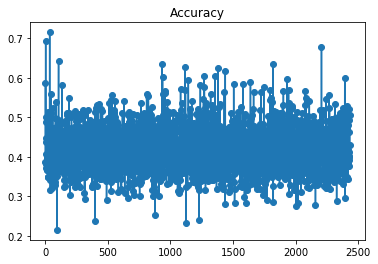

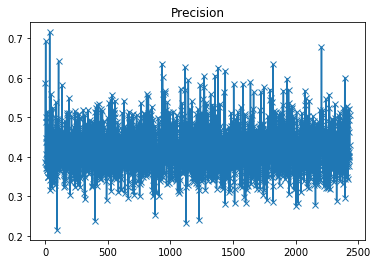

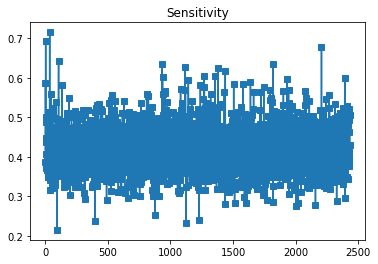

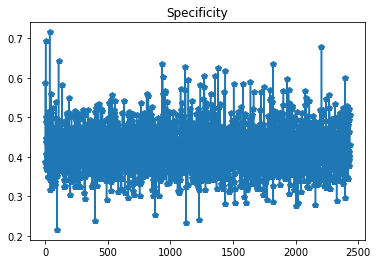

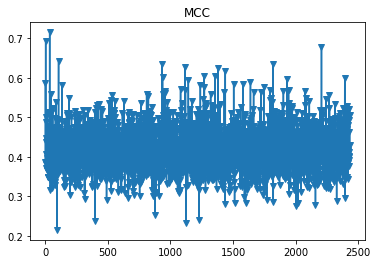

(array([0.58762887, 0.38765432, 0.40616967, ..., 0.39276486, 0.50639386,
        0.42964824]),
 array([0.58762887, 0.38765432, 0.40616967, ..., 0.39276486, 0.50639386,
        0.42964824]),
 array([0.58762887, 0.38765432, 0.40616967, ..., 0.39276486, 0.50639386,
        0.42964824]),
 array([0.58762887, 0.38765432, 0.40616967, ..., 0.39276486, 0.50639386,
        0.42964824]),
 array([0.58762887, 0.38765432, 0.40616967, ..., 0.39276486, 0.50639386,
        0.42964824]))

In [83]:
subopt = load_performances('subopt')

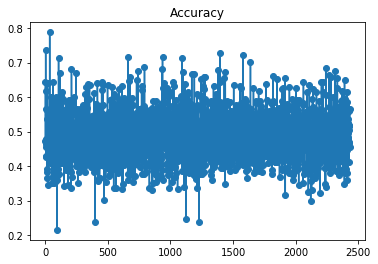

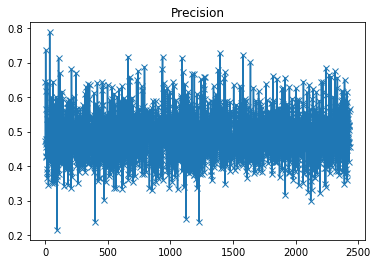

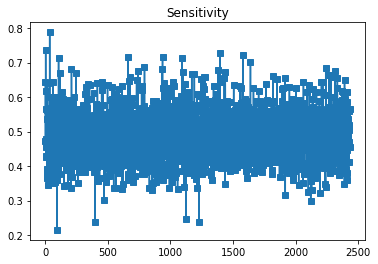

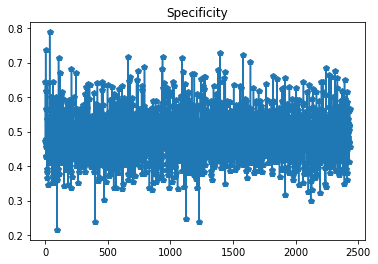

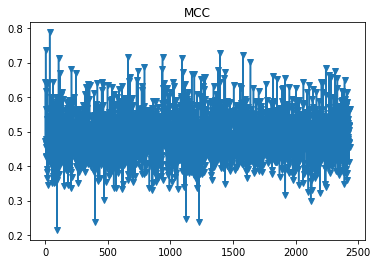

(array([0.6443299 , 0.47160494, 0.45501285, ..., 0.50387597, 0.56521739,
        0.45477387]),
 array([0.6443299 , 0.47160494, 0.45501285, ..., 0.50387597, 0.56521739,
        0.45477387]),
 array([0.6443299 , 0.47160494, 0.45501285, ..., 0.50387597, 0.56521739,
        0.45477387]),
 array([0.6443299 , 0.47160494, 0.45501285, ..., 0.50387597, 0.56521739,
        0.45477387]),
 array([0.6443299 , 0.47160494, 0.45501285, ..., 0.50387597, 0.56521739,
        0.45477387]))

In [84]:
duplex = load_performances('duplex')

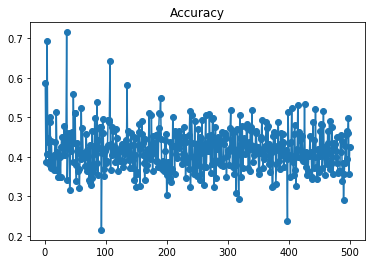

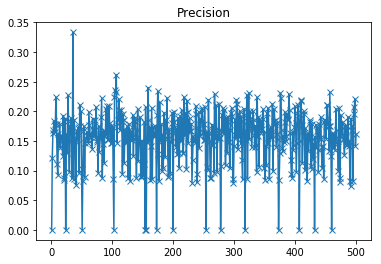

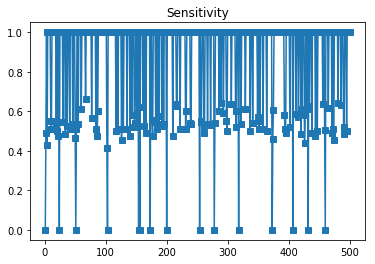

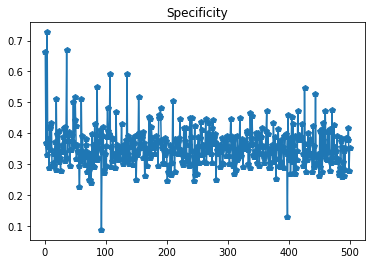

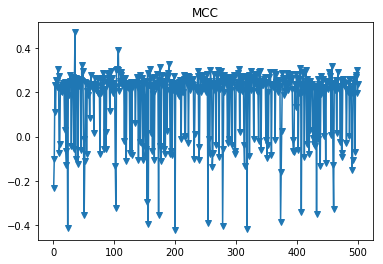

In [80]:
plot_performances(subopt, 500)

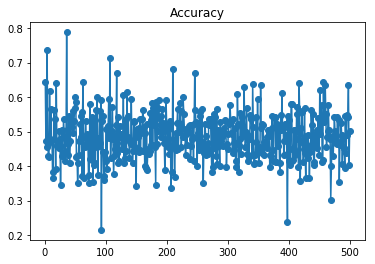

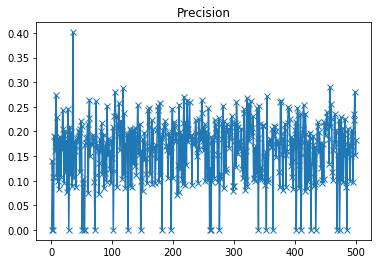

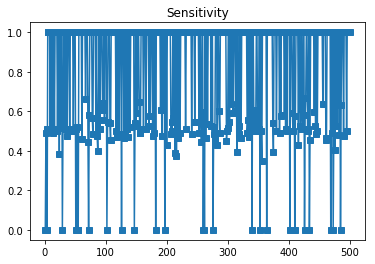

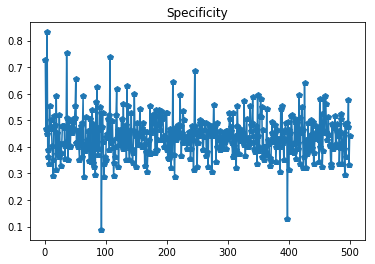

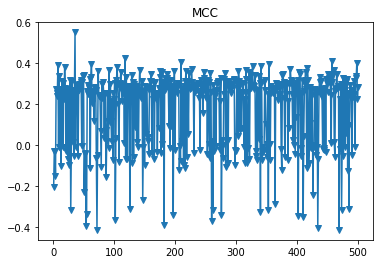

In [81]:
plot_performances(duplex, 500)